# Examples

To give a thorough example of what the library allows to implement, in this [Jupyter](https://jupyter.org/) session we follow rather faitfully some Sections of [Parsing Techniques](https://dickgrune.com//Books/PTAPG_2nd_Edition/), an eccellent book on parsing by Dick Grune and Ceriel J.H. Jacobs. We can omit many details (such as defintions, proofs, careful algorithm explanations…) but the interested reader can still find in such text a very precise, clear and conceputal description of the ideas behind the code implemented in the following examples.


## Type 1 grammars and production graphs

Let's start defining a *monotonic* grammar for $a^nb^nc^n$

In [1]:
from liblet import Grammar

G = Grammar.from_string("""
S -> a b c
S -> a S Q
b Q c -> b b c c
c Q -> Q c
""", False)

G

Grammar(N={Q, S}, T={a, b, c}, P=(S -> a b c, S -> a S Q, b Q c -> b b c c, c Q -> Q c), S=S)

It can be convenient to show the productions as a table, with numbered rows.

In [2]:
from liblet import iter2table

iter2table(G.P)

It's now time to create a *derivation* of $a^2b^2c^2$

In [3]:
from liblet import Derivation

d = Derivation(G).step(1, 0).step(0, 1).step(3, 3).step(2, 2)
d

S -> a S Q -> a a b c Q -> a a b Q c -> a a b b c c

It can be quite illuminating to see the *production graph* for such derivation

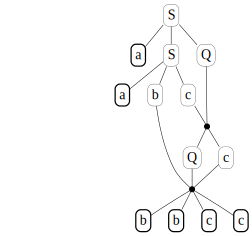

In [4]:
from liblet import ProductionGraph

ProductionGraph(d)

## Context-free grammars and ambiguity

Assume we want to experiment with an ambiguous grammar and look for two different leftmost derivation of the same sentence.

To this aim, let's consider the following grammar and a short derivation leading to and addition of three terminals

In [5]:
G = Grammar.from_string("""
E -> E + E
E -> E * E
E -> i
""")

d = Derivation(G).step(0, 0).step(0, 0)
d

E -> E + E -> E + E + E

What are the possible steps at this point? The `possible_steps` method comes in handy, here is a (numbered) table of pairs $(p, q)$ where $p$ is production number and $q$ the position of the nonterminal that can be substituted:

In [6]:
possible_steps = list(d.possible_steps())
iter2table(possible_steps)

If we look for just for leftmost derivations among the $(p, q)$s, we must keep just the $p$s corresponding to the $q$s equal to the minimum of the possible $q$ values. The following function can be used to such aim:

In [7]:
from operator import itemgetter

def filter_leftmost_prods(possible_steps):
    possible_steps = list(possible_steps)
    if possible_steps:
        min_q = min(possible_steps, key = itemgetter(1))[1]
        return map(itemgetter(0), filter(lambda ps: ps[1] == min_q, possible_steps))
    return tuple()

list(filter_leftmost_prods(possible_steps))

[0, 1, 2]

Now, using a `Queue` we can enumerate all the leftmost productions, we can have a fancy generator that returns a new derivation each time `next` is called on it:

In [8]:
from liblet import Queue

def derivation_generator(G):
    Q = Queue([Derivation(G)])
    while Q:
        derivation = Q.dequeue()
        if set(derivation.sentential_form()) <= G.T: 
            yield derivation
        for nprod in filter_leftmost_prods(derivation.possible_steps()):
            Q.enqueue(derivation.leftmost(nprod))

Let's collect the first 10 derivations

In [9]:
derivation = derivation_generator(G)
D = [next(derivation) for _ in range(10)]
iter2table(D)

As one can easily see, derivations 6 and 7 produce the same sentence `i + i * i` but evidently with two different leftmost derivations. We can give a look at the production graphs to better see what is happening.

In [10]:
from liblet import side_by_side

side_by_side(ProductionGraph(D[6]), ProductionGraph(D[7]))

## Hygiene in Context-Free Grammars

First of all, let's start with a series of techniques to clean a *context-free* grammar by removing *unreachable*, *non-productive*, and *undefined* symbols. Let's start with the *context-free* grammar $G$ of Figure 2.25 at page 49 of [Parsing Techniques](https://dickgrune.com//Books/PTAPG_2nd_Edition/), in particular we'll be following the flow of Sections 2.9.1, 2.9.2 and 2.9.5.

In [11]:
G = Grammar.from_string("""
S -> A B | D E
A -> a
B -> b C
C -> c
D -> d F 
E -> e 
F -> f D
""")

We can use the `@closure` decorator to obtain the *productive* symbols by extending at every round the set `prod` of productive symbols as `{A for A, α in G.P if set(α) <= prod}`, that is taking all the left-hand sides of productions whose left-hand sides are in turn made of productive symbols.

In [12]:
from liblet import closure

def find_productive(G):
    @closure
    def find(prod):
        return prod | {A for A, α in G.P if set(α) <= prod}
    return set(find(G.T))

In [13]:
find_productive(G)

{'A', 'B', 'C', 'E', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

Similarly, we can obtain the *reachable* symbols by extending at every round the set `reach` of reachable symbols as `union_of(set(α) for A, α in G.P if A in reach)}`, that is taking the union all the left-hand sides of productions whose left-hand sides are in turn reachable.

In [14]:
from liblet import union_of

def find_reachable(G):
    @closure
    def find(reach, G):
        return reach | union_of(set(α) for A, α in G.P if A in reach)
    return find({G.S}, G)   

In [15]:
find_reachable(G)

{'A', 'B', 'C', 'D', 'E', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

To clean the grammar one has first to eliminate the non-productive symbols and the the non-reachable onse (as acting in the reverse order can leave around non-reachable symbols after the first removal).

In [16]:
def remove_unproductive_unreachable(G):
    Gp = G.restrict_to(find_productive(G))
    return Gp.restrict_to(find_reachable(Gp))

In [17]:
remove_unproductive_unreachable(G)

Grammar(N={A, B, C, S}, T={a, b, c}, P=(S -> A B, A -> a, B -> b C, C -> c), S=S)

To remove *undefined* nonterminals is easy, it's enough to collect the ones appearing as left-hand side in some production and throw away the others

In [18]:
def remove_undefined(G):
    return G.restrict_to({A for A, α in G.P} | G.T)

Given that `Grammar.from_string` considers nonterminal just the symbols on the left-hand sides, to check that the last method works we need to build a grammar in another way:

In [19]:
from liblet import Production

Gu = Grammar({'S', 'T'}, {'s'}, (Production('S', ('s',)),), 'S')
Gu

Grammar(N={S, T}, T={s}, P=(S -> s,), S=S)

In [20]:
remove_undefined(Gu)

Grammar(N={S}, T={s}, P=(S -> s,), S=S)

Observe that undefined symbols are non-productive, hence `remove_unproductive_unreachable` will take implicitly care of them.

## The Chomsky Normal Form

Now that the grammar contains only defined, productive and reachable symbols, to get to the CHomsky normal form we need to take care of ε-rules and unit rules (following Section 4.2.3 of [Parsing Techniques](https://dickgrune.com//Books/PTAPG_2nd_Edition/)).

### Elimination of ε-rules

The elimination of ε-rules is performed in a series of consecutive steps, adding new nonterminals and productions.

As an example grammar we use the one of Figure 4.10 at page 120.

In [21]:
G = Grammar.from_string("""
S -> L a M
L -> L M 
L -> ε
M -> M M
M -> ε
""")

Given a rule $A\to ε$ we look for rules of the form $B\to αAβ$ and "inline" the ε-rule by
adding two new rules $B\to αA'β$ and $B\to αβ$ where $A'$ is a new nonterminal; this of course need to be iterated (in a closure) to cope with productions where $A$ appears more than once in the left-hand side.

In [22]:
@closure
def replace_in_rhs(G, A):
    Ap = A + '’'
    prods = set()
    for B, β in G.P:
        if A in β:
            pos = β.index(A)
            rhs = β[:pos] + β[pos + 1:]
            if len(rhs) == 0: rhs = ('ε', )
            prods.add(Production(B, rhs))
            prods.add(Production(B, β[:pos] + (Ap, ) + β[pos + 1:]))
        else:
            prods.add(Production(B, β))    
    return Grammar(G.N | {Ap}, G.T, prods, G.S)

In [23]:
from liblet import prods2table

Gp = replace_in_rhs(G, 'M')
prods2table(Gp)

The above procedure must be repeated for evey ε-rule, moreover since the process can intruduce new ε-rules, a closure is again needed.

In [24]:
@closure
def inline_ε_rules(G_seen):
    G, seen = G_seen
    for A in G.N - seen:
        if ('ε', ) in G.alternatives(A):
            return replace_in_rhs(G, A), seen | {A}
    return G, seen

In [25]:
Gp, _ = inline_ε_rules((G, set()))
prods2table(Gp)

The left-hand sides of the ε rules now are unreachable, but the new "primed" nonterminals must now be defined, using the non-empty left-hand sides of the one they inlined.

In [26]:
def eliminate_ε_rules(G):
    Gp, _ = inline_ε_rules((G, set()))
    prods = set(Gp.P)
    for Ap in Gp.N - G.N:
        A = Ap[:-1]
        for α in set(Gp.alternatives(A)) - {('ε', )}:
            prods.add(Production(Ap, α))
    return Grammar(Gp.N, Gp.T, prods, Gp.S)

In [27]:
prods2table(eliminate_ε_rules(G))

Removing the unreachable and non-productive rules leads to quite a drastic simplification!

In [28]:
remove_unproductive_unreachable(eliminate_ε_rules(G))

Grammar(N={S}, T={a}, P=(S -> a,), S=S)

### Elimination of unit rules

To see what happens dealing with rules of the form $A\to B$ we'll refer to a more complex grammar, the one of Figure 4.6 at page 112.

In [29]:
G = Grammar.from_string("""
Number -> Integer | Real
Integer -> Digit | Integer Digit
Real -> Integer Fraction Scale
Fraction -> . Integer
Scale -> e Sign Integer | Empty
Digit -> 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
Sign -> + | -
Empty -> ε
""")
prods2table(G)

We start by applying all the cleaning steps seen so far.

In [30]:
Gorig = G
G = remove_unproductive_unreachable(eliminate_ε_rules(G))
prods2table(G)

The elimination of the unit rules is based again on a closure that replaces $A\to B$ 
and $B\to α$ with $A\to α$.

In [31]:
def eliminate_unit_rules(G):
    @closure
    def clean(G_seen):
        G, seen = G_seen
        for P in set(filter(Production.such_that(rhs_len = 1), G.P)) - seen:
            A, (B, ) = P
            if B in G.N:            
                prods = (set(G.P) | {Production(A, α) for α in G.alternatives(B)}) - {P}
                return Grammar(G.N, G.T, prods, G.S), seen | {P}
        return G, seen
    return clean((G, set()))[0]

In [32]:
G = eliminate_unit_rules(G)
prods2table(G)

### The normal form

Two last cases need to be taken care of to get to the CNF. 

First we want to eliminate non-solitary terminals in left-hand sides, that is if $A\to αaβ$ where $a\in T$ and $α, β\in N^*$; this is easily solved by introducing a new nonterminal $N_a$ and a new rule $N_a\to a$, replacing the offending $A\to αaβ$ with $A\to αN_aβ$.

In [33]:
def transform_nonsolitary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 1 and set(α) & G.T:
            rhs = []
            for x in α:
                if x in G.T:
                    N = 'N{}'.format(x)
                    prods.add(Production(N, (x, )))
                    rhs.append(N)
                else:
                    rhs.append(x)
            prods.add(Production(A, rhs))
        else:            
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [34]:
G = transform_nonsolitary(G)
prods2table(G)

Finally we need to shorten left-hand sides longer than 2 symbols. Again that is easily accomplished by introducing new nonterminals and rules.

In [35]:
def make_binary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 2:
            Ai = '{}{}'.format(A, 1)
            prods.add(Production(Ai, α[:2]))
            for i, Xi in enumerate(α[2:-1], 2):
                prods.add(Production('{}{}'.format(A, i), (Ai, Xi)))
                Ai = '{}{}'.format(A, i)
            prods.add(Production(A, (Ai, α[-1])))
        else:
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)


In [36]:
G = make_binary(G)
prods2table(G)

## The Cocke, Younger, and Kasami algorithm

Following the CYK description given in Section 4.2.2 of [Parsing Techniques](https://dickgrune.com//Books/PTAPG_2nd_Edition/) we implement the algoritm by means of a dictionary `R` that, for the key $(i, l)$, records the left-hand sides of productions deriving $s_{il}$ that is the substring of the input starting at $i$ and having length $l$.

In [37]:
def cyk(G, INPUT):
    def fill(R, i, l):
        res = set()
        if l == 1:
            for A, (a,) in filter(Production.such_that(rhs_len = 1), G.P): 
                if a == INPUT[i - 1]:
                    res.add(A)
        else:
            for k in range(1, l):
                for A, (B, C) in filter(Production.such_that(rhs_len = 2), G.P):
                    if B in R[(i, k)] and C in R[(i + k, l - k)]:
                        res.add(A)
        return res
    R = {}
    for l in range(1, len(INPUT) + 1):
        for i in range(1, len(INPUT) - l + 2): 
            R[(i, l)] = fill(R, i, l)
    return R

In [38]:
from liblet import cyk2table

INPUT = '32.5e+1'
R = cyk(G, INPUT)
cyk2table(R)

### Getting the derivation from the table

Once the table is filled, it's easy to get a leftmost production by recursing in the table following the same logic used to fill it.

In [39]:
from liblet import show_calls

def get_leftmost_prods(G, R, INPUT):
    @show_calls(True)
    def prods(X, i, l):
        if l == 1:
            return [G.P.index(Production(X, (INPUT[i - 1],)))]
        for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
            for k in range(1, l):
                if B in R[(i, k)] and C in R[(i + k, l - k)]:
                    return [G.P.index(Production(A, (B, C)))] + prods(B, i, k) + prods(C, i + k, l - k)
    return prods(G.S, 1, len(INPUT))            

In [40]:
prods = get_leftmost_prods(G, R, INPUT)

┌prods('Number', 1, 7)
│┌prods('Number1', 1, 4)
││┌prods('Integer', 1, 2)
│││┌prods('Integer', 1, 1)
│││└─ [36]
│││┌prods('Digit', 2, 1)
│││└─ [1]
││└─ [6, 36, 1]
││┌prods('Fraction', 3, 2)
│││┌prods('N.', 3, 1)
│││└─ [37]
│││┌prods('Integer', 4, 1)
│││└─ [20]
││└─ [40, 37, 20]
│└─ [12, 6, 36, 1, 40, 37, 20]
│┌prods('Scale’', 5, 3)
││┌prods('Scale’1', 5, 2)
│││┌prods('Ne', 5, 1)
│││└─ [10]
│││┌prods('Sign', 6, 1)
│││└─ [28]
││└─ [18, 10, 28]
││┌prods('Integer', 7, 1)
││└─ [43]
│└─ [23, 18, 10, 28, 43]
└─ [25, 12, 6, 36, 1, 40, 37, 20, 23, 18, 10, 28, 43]


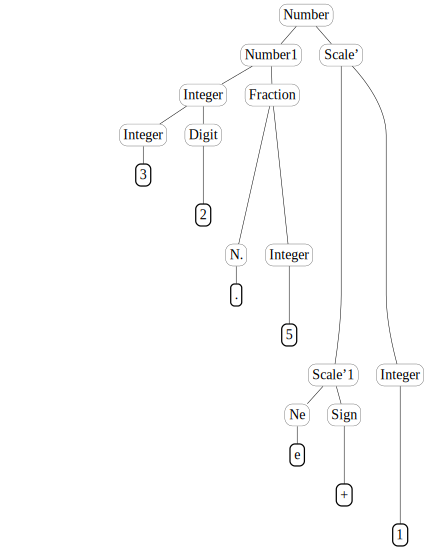

In [41]:
d = Derivation(G)
for step in prods: d = d.leftmost(step)
ProductionGraph(d)

### Undoing the grammar transformation

Following section 4.2.6 of [Parsing Techniques](https://dickgrune.com//Books/PTAPG_2nd_Edition/), one can undo the CNF transformation keeping track in `R` of symbols that became useless after the the elimination of ε-rules and unit rules, that is we clean the original grammar but avoid the `remove_unproductive_unreachable` step.

In [42]:
Gp = eliminate_unit_rules(eliminate_ε_rules(Gorig))
Gp = transform_nonsolitary(make_binary(Gp))
prods2table(Gp)

We again perform the parsing, this time saving the results in `Roirg` table, to which add the end we add a last line with the ε-rules `Rε`.

In [43]:
Rorig = cyk(Gp, INPUT)

Rε = {A for A in Gp.N if ('ε', ) in Gp.alternatives(A)}
for i in range(1, len(INPUT) + 2): Rorig[(i, 0)] = Rε
    
cyk2table(Rorig)

To recover the parse tree, we need a recursive function `derives(ω, i, l)` (depending on the grammar and the parse table) that for a given substring $ω\in (T\cup N)^*$ returns a `True, lst` if $ω$ derives the substring $s_{il}$ and `lst` is a list $\lambda_0, \lambda_1, \lambda_{l-1}$ such that $\lambda_i$ is the length of the substring derived by $w_i$.

In [44]:
def make_derives(R, INPUT):
    def derives(ω, i, l):
        if not ω or ('ε', ) == ω: return l == 0, []
        X, *χ = ω
        if X in G.T:
            if i <= len(INPUT) and X == INPUT[i - 1]:
                d, s = derives(χ, i + 1, l - 1)
                if d: return True, [1] + s
        else:
            for k in range(0, l + 1):
                if X in R[(i, k)]:
                    d, s = derives(χ, i + k, l - k)
                    if d: return True, [k] + s
        return False, []
    return derives

We can for instance test that `Integer Fraction Scale` derives $s_{1,4} =$ `32.5` as

In [45]:
derives = make_derives(Rorig, INPUT)
derives(['Integer', 'Fraction', 'Scale'], 1, 4)

(True, [2, 2, 0])

That tells us that `Integer` derives the first 2 input symbols `32`, then `Fraction` derives the last 2 symbols `.5` and finally `Scale` derives the empty string.

Endowed with such function, it is easy to adatp `get_leftmost_prods` so that it works also for  the productions of the original grammar, that are not in CNF (and can hence have arbitrary length and contain non-solitary terminals).

In [46]:
def get_original_leftmost_prods(G, derives, N):
    @show_calls(True)
    def prods(X, i, l):
        if X in G.T: return []
        for A, α in filter(Production.such_that(lhs = X), G.P):
            d, sp = derives(α, i, l)
            if not d: continue
            res = [G.P.index(Production(A, α))]
            for B, l in zip(α, sp): 
                res.extend(prods(B, i, l))
                i += l
            return res
    return prods(G.S, 1, N)

In [47]:
prods_orig = get_original_leftmost_prods(Gorig, derives, len(INPUT))
prods_orig

┌prods('Number', 1, 7)
│┌prods('Real', 1, 7)
││┌prods('Integer', 1, 2)
│││┌prods('Integer', 1, 1)
││││┌prods('Digit', 1, 1)
│││││┌prods('3', 1, 1)
│││││└─ []
││││└─ [11]
│││└─ [2, 11]
│││┌prods('Digit', 2, 1)
││││┌prods('2', 2, 1)
││││└─ []
│││└─ [10]
││└─ [3, 2, 11, 10]
││┌prods('Fraction', 3, 2)
│││┌prods('.', 3, 1)
│││└─ []
│││┌prods('Integer', 4, 1)
││││┌prods('Digit', 4, 1)
│││││┌prods('5', 4, 1)
│││││└─ []
││││└─ [13]
│││└─ [2, 13]
││└─ [5, 2, 13]
││┌prods('Scale', 5, 3)
│││┌prods('e', 5, 1)
│││└─ []
│││┌prods('Sign', 6, 1)
││││┌prods('+', 6, 1)
││││└─ []
│││└─ [18]
│││┌prods('Integer', 7, 1)
││││┌prods('Digit', 7, 1)
│││││┌prods('1', 7, 1)
│││││└─ []
││││└─ [9]
│││└─ [2, 9]
││└─ [6, 18, 2, 9]
│└─ [4, 3, 2, 11, 10, 5, 2, 13, 6, 18, 2, 9]
└─ [1, 4, 3, 2, 11, 10, 5, 2, 13, 6, 18, 2, 9]


[1, 4, 3, 2, 11, 10, 5, 2, 13, 6, 18, 2, 9]

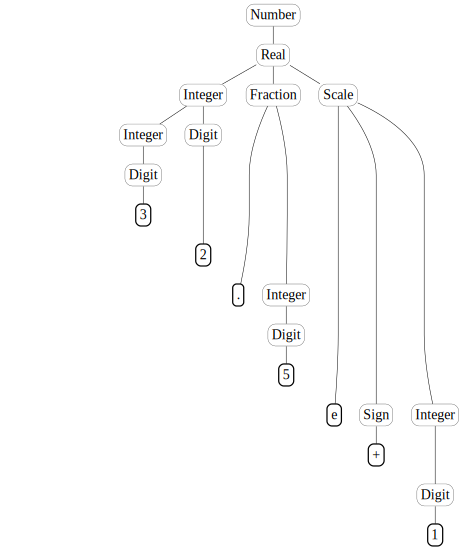

In [48]:
d = Derivation(Gorig)
for step in prods_orig: d = d.leftmost(step)
ProductionGraph(d)